In [1]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import logging
import argparse
import yaml
import os
import pandas as pd

from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset

from models.encoder import res_encoderS
from models.EEGNET import EEGNet

from models.classifier import transformer_classifier

2024-12-04 10:47:16.174843: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 10:47:16.194788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 10:47:16.567291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("config_file", metavar="FILE", help="config file")
# parser.add_argument('--run-dir', metavar='DIR', help='run directory')
# parser.add_argument('--pdb', action='store_true', help='pdb')
args = parser.parse_args(args=['configs/EEGNet.yml'])
# args, opts = parser.parse_known_args()
# f = 'configs/eeg_pt.yml'
with open(args.config_file, 'r') as file:
    Configs = yaml.safe_load(file)

In [3]:
logger = logging.getLogger(__name__)  # Use the current module's name
# logging.basicConfig(level=logging.ERROR)
logging.basicConfig(level=logging.INFO)
# logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# handler.setFormatter(formatter)
logger.addHandler(handler)
acc_example = 0.95  # Replace with your actual accuracy calculation
logger.info(f"Current accuracy: %{acc_example}")  # Log as info
# logger.debug("Current accuracy: %.2f", accuracy)  # Log as info

Current accuracy: %0.95
INFO:__main__:Current accuracy: %0.95


In [4]:
# Transform signal
def transform(data:Tensor, mean:Tensor, std:Tensor):
    normalized_data = (data - mean) / std
    return normalized_data

# ### Dataset

class customDataset(Dataset):
    def __init__(self, data_dir:str, label_dir:str, label_dict:dict, mean: list, std: list, transform=None):
        
        self.data_dir = data_dir   # './data/seg_csv/train'
        self.label_dir = label_dir
        self.transform = transform
        self.files = os.listdir(self.data_dir)
        self.annotations = pd.read_csv(self.label_dir)
        self.label_dict = label_dict
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        data_path = os.path.join(self.data_dir, self.files[index])
        data = pd.read_csv(data_path)
        data = torch.tensor(data.values, dtype=torch.float32)
        file_name = self.files[index]
        
#         label = torch.tensor(int(self.label_dict[self.annotations.iloc[index,1]]))
        label = self.annotations.loc[self.annotations['csv_file'] == file_name, ['label']].to_string(index=False,header=False)
        label = torch.tensor(int(self.label_dict[label]))
        
        
        if self.transform:
            data = self.transform(data, self.mean, self.std)
            
        return (data, label, file_name)

In [5]:
### My network
class model(nn.Module):
        def __init__(self, input_size: int, n_channels: int, model_hyp: dict, classes: int):
            super(model, self).__init__()
            self.ae = res_encoderXS(n_channels=n_channels, groups=n_channels, num_classes=classes, d_model=model_hyp['d_model'])
            self.transformer_encoder = transformer_classifier(input_size, n_channels, model_hyp, classes)

            self.reset_parameters()

        def reset_parameters(self):
            r"""Initiate parameters in the model."""

            for p in self.parameters():
                if p.dim() > 1:
    #                 logger.debug(p.shape)
                    nn.init.xavier_uniform_(p)

            for m in self.modules():
    #             print(m)
                if isinstance(m, nn.Conv1d):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)

                elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
                    nn.init.ones_(m.weight)
                    nn.init.zeros_(m.bias)
                elif isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)
            print('Complete initiate parameters')

        def forward(self, x):
    #         z = self.pe(x)
            z = x.transpose(-1,-2)
            z = self.ae(z)
    #         z = torch.flatten(z, 1)
    #         y = self.mlp(z)
            y = self.transformer_encoder(z)
            return y


# Load your trained model
def load_model(model_path):
    model = torch.load(model_path)
    model = model.to('cuda')
    model.eval()  # Set the model to evaluation mode
    return model


In [6]:
# Predict a single signal
def predict_signal(model, signal):
    with torch.no_grad():
        output = model(signal)
        # For NNGNet
#         output = model(signal.unsqueeze(1)).to('cpu')
        
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class
    return prediction

# Calculate sensitivity, specificity, and accuracy
def calculate_metrics(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.tolist()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.tolist()
        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return sensitivity, specificity, accuracy

# Evaluate per-signal metrics
def evaluate_per_signal(model, dataset):
    y_true, y_pred = [], []
    for signal, label, _ in dataset:
        signal= signal.to('cuda')
        if isinstance(label, torch.Tensor):
            label = label.item()
        prediction = predict_signal(model, signal)
        y_true.append(label)
        y_pred.append(prediction)
    sensitivity, specificity, accuracy = calculate_metrics(y_true, y_pred)
    return sensitivity, specificity, accuracy, y_true, y_pred

# Aggregate signals for per-case metrics
def evaluate_per_case(y_true, y_pred, signal_to_case_map):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.tolist()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.tolist()
        
    case_results = {}
    for signal_idx, case_id in enumerate(signal_to_case_map):
        if case_id not in case_results:
            case_results[case_id] = {'true': [], 'pred': []}
        case_results[case_id]['true'].append(y_true[signal_idx])
        case_results[case_id]['pred'].append(y_pred[signal_idx])

    # Per-case metrics
    y_true_case, y_pred_case = [], []
    for case_id, results in case_results.items():
        # Majority vote for case prediction
        true_label = max(set(results['true']), key=results['true'].count)
        pred_label = max(set(results['pred']), key=results['pred'].count)
        y_true_case.append(true_label)
        y_pred_case.append(pred_label)

    sensitivity, specificity, accuracy = calculate_metrics(y_true_case, y_pred_case)
    return sensitivity, specificity, accuracy, y_true_case, y_pred_case

In [7]:
# Main script
def main():
    eval_data_dir = Configs['dataset']['val_data_dir']
    eval_label_dir = Configs['dataset']['val_label_dir']
    label_dict = Configs['dataset']['classes']
    mean = Configs['dataset']['mean']
    std = Configs['dataset']['std']
    eval_dataset = customDataset(data_dir=eval_data_dir,
                                label_dir=eval_label_dir,
                                label_dict=label_dict,
                               mean=mean, std=std,
                               transform=transform)

    dataloader = DataLoader(dataset=eval_dataset, num_workers=Configs['dataset']['num_workers'], 
                             shuffle=False, pin_memory=True)  # Replace with your dataset loader, e.g., [(signal, label), ...]
    
    
    signal_to_case_map = []  # Map each signal index to a case ID, e.g., [case1, case1, case2, ...]
    for data, label, file_name in dataloader:
        signal_to_case_map.append(file_name[0].split('_')[0])

    # Load the trained model
#     model_path = Configs['checkpoint']['checkpoint_dir']+Configs['checkpoint']['weights']
    model_path = '../weights/2411260952_encoderS+transformer_params_epoch_3_bestacc0.779872.pth'
    model = load_model(model_path)
    # For EEGNet
#     model = EEGNet(signal_length=Configs['input_size'],channel=Configs['n_channels'],
#                fs=Configs['processing']['frequency'],
#                 num_class=len(Configs['dataset']['classes'])
#                ).to('cpu')
#     model.load_state_dict(torch.load(model_path))

    # Per-signal evaluation
    print("Evaluating per-signal metrics...")
    sensitivity_signal, specificity_signal, accuracy_signal, y_true_signal, y_pred_signal = evaluate_per_signal(
        model, dataloader)
    print(f"Per-Signal Sensitivity: {sensitivity_signal:.4f}, Specificity: {specificity_signal:.4f}, Accuracy: {accuracy_signal:.4f}")

    # Per-case evaluation
    print("Evaluating per-case metrics...")
    sensitivity_case, specificity_case, accuracy_case, y_true_case, y_pred_case = evaluate_per_case(
        y_true_signal, y_pred_signal, signal_to_case_map)
    print(f"Per-Case Sensitivity: {sensitivity_case:.4f}, Specificity: {specificity_case:.4f}, Accuracy: {accuracy_case:.4f}")

In [8]:
if __name__ == "__main__":
#     model_path = '../2411252344_encoderS+transformer_params_epoch_2_bestacc0791252.pth'
#     classifier = torch.load(model_path)
    main()

/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytre

Evaluating per-signal metrics...


/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytre

Per-Signal Sensitivity: 0.7579, Specificity: 0.7986, Accuracy: 0.7799
Evaluating per-case metrics...
Per-Case Sensitivity: 0.7905, Specificity: 0.8243, Accuracy: 0.8103


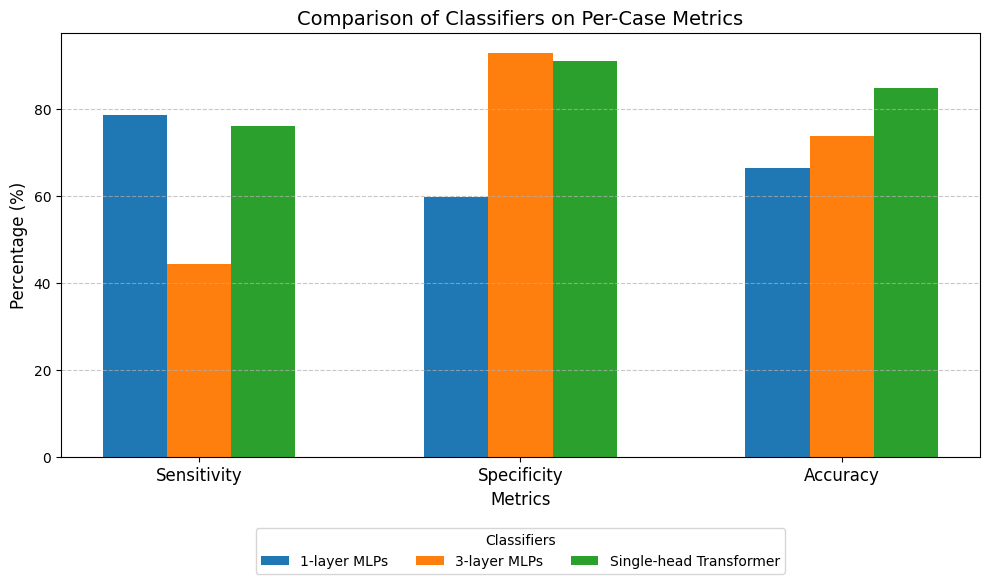

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the classifiers
classifiers = ["1-layer MLPs", "3-layer MLPs", "Single-head Transformer"]
metrics = ["Sensitivity", "Specificity", "Accuracy"]
per_signal = [
    [78.7, 59.8, 66.4],  # 1-layer MLPs
    [44.4, 92.9, 73.9],  # 3-layer MLPs
    [76.2, 91.2, 85.0]   # Single-head Transformer
]

# Convert data to numpy array for easier handling
data = np.array(per_signal)

# Bar chart settings
x = np.arange(len(metrics))  # the label locations
bar_width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each classifier
for i, classifier in enumerate(classifiers):
    ax.bar(x + i * bar_width, data[i], bar_width, label=classifier)

# Add labels, title, and legend
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Comparison of Classifiers on Per-Case Metrics", fontsize=14)
ax.set_xticks(x + bar_width)  # Position ticks in the middle of grouped bars
ax.set_xticklabels(metrics, fontsize=12)

# Place the legend outside the plot area to avoid overlapping
ax.legend(title="Classifiers", fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
fig.savefig("../results/ablation_per-case.png", dpi=300, bbox_inches="tight")  # Saves as PNG with high resolution
plt.tight_layout()
plt.show()


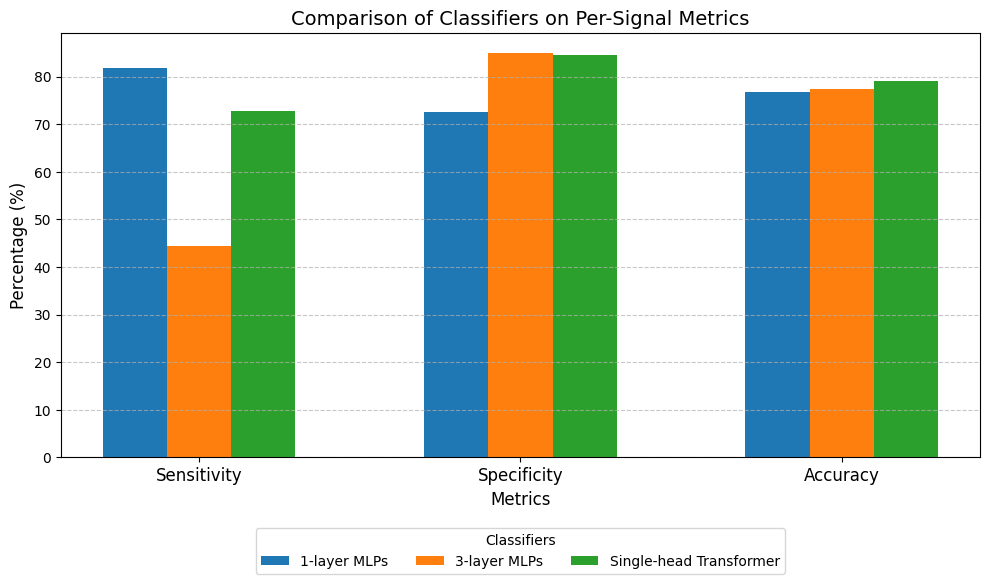

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the classifiers
classifiers = ["1-layer MLPs", "3-layer MLPs", "Single-head Transformer"]
metrics = ["Sensitivity", "Specificity", "Accuracy"]
per_signal = [
    [81.7, 72.6, 76.8],  # 1-layer MLPs
    [44.4, 84.9, 77.4],  # 3-layer MLPs
    [72.8, 84.5, 79.1]   # Single-head Transformer
]

# Convert data to numpy array for easier handling
data = np.array(per_signal)

# Bar chart settings
x = np.arange(len(metrics))  # the label locations
bar_width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each classifier
for i, classifier in enumerate(classifiers):
    ax.bar(x + i * bar_width, data[i], bar_width, label=classifier)

# Add labels, title, and legend
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Comparison of Classifiers on Per-Signal Metrics", fontsize=14)
ax.set_xticks(x + bar_width)  # Position ticks in the middle of grouped bars
ax.set_xticklabels(metrics, fontsize=12)

# Place the legend outside the plot area to avoid overlapping
ax.legend(title="Classifiers", fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
fig.savefig("../results/ablation_per-signal.png", dpi=300, bbox_inches="tight")  # Saves as PNG with high resolution
plt.tight_layout()
plt.show()
